In [67]:
import numpy as np
import matplotlib.pyplot as plt
import inspect

In [68]:
import importlib
import sys
sys.path.append('../')
from Utils.perturbationsnew import RBPIndividual, RBPIndividualNew1, RBPIndividualNew2, zeroPerturb, noisePerturb, blurPerturb
from Utils.models import *
from Utils.data import perturb, generateSynthetic, generateSyntheticPerturbReal,ReadTS

print(sys.path)


['/Users/gali/anaconda3/envs/LIMEtf/lib/python310.zip', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10/lib-dynload', '', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10/site-packages', '/Users/gali/anaconda3/envs/LIMEtf/lib/python3.10/site-packages/setuptools/_vendor', '../', '../', '../', '../']


## Test important content removal (accuracy decrease)

### Load synthetic dataset and train CNN model 

In [87]:
x_test_original, y_test_original,x_train, y_train = ReadTS('ChlorineConcentration')
y_train = y_train - 1
y_test_original = y_test_original - 1
print(x_train.shape)
print(y_test_original)
y_test_original = y_test_original.astype(int)
print(np.bincount(y_test_original))

(3840, 166, 1)
[0. 2. 0. 2. 1. 0. 0. 0. 2. 2. 0. 2. 1. 2. 0. 0. 2. 2. 2. 2. 1. 2. 2. 1.
 1. 0. 2. 2. 1. 2. 2. 0. 0. 2. 0. 2. 0. 2. 0. 2. 2. 2. 1. 1. 0. 2. 1. 1.
 2. 2. 2. 1. 2. 2. 1. 1. 2. 1. 2. 2. 2. 0. 2. 2. 2. 0. 2. 2. 2. 2. 1. 2.
 0. 1. 0. 1. 2. 2. 2. 2. 0. 0. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 0. 2. 0. 0.
 2. 2. 0. 2. 2. 0. 0. 0. 2. 2. 2. 1. 2. 2. 1. 0. 1. 2. 2. 2. 1. 0. 1. 0.
 2. 0. 0. 2. 1. 2. 2. 1. 2. 0. 2. 2. 0. 2. 2. 2. 0. 0. 0. 2. 2. 2. 2. 2.
 2. 0. 1. 0. 2. 1. 2. 2. 2. 0. 1. 2. 2. 1. 1. 0. 2. 0. 2. 2. 2. 0. 2. 0.
 0. 2. 1. 0. 2. 2. 2. 2. 2. 0. 2. 0. 1. 2. 1. 2. 2. 1. 1. 2. 2. 0. 2. 2.
 2. 2. 2. 1. 1. 2. 1. 2. 2. 2. 2. 0. 2. 2. 0. 2. 2. 2. 2. 2. 2. 1. 1. 0.
 2. 1. 0. 2. 2. 1. 2. 0. 2. 2. 1. 0. 2. 0. 2. 1. 2. 0. 2. 1. 1. 2. 1. 2.
 2. 2. 1. 2. 2. 0. 1. 0. 0. 0. 2. 1. 2. 1. 2. 1. 0. 2. 1. 2. 1. 2. 0. 1.
 2. 2. 0. 1. 2. 2. 0. 2. 2. 1. 0. 2. 0. 2. 1. 2. 0. 2. 2. 2. 0. 0. 2. 1.
 2. 1. 2. 1. 2. 2. 0. 2. 2. 0. 2. 1. 2. 0. 1. 0. 2. 2. 2. 0. 0. 0. 2. 2.
 2. 1. 2. 0. 2. 1. 0. 0. 0. 1. 0. 0.

In [70]:
x_test_original, y_test_original,x_train, y_train = ReadTS('ChlorineConcentration')
y_train = y_train - 1
y_test_original = y_test_original - 1

from sklearn.preprocessing import StandardScaler
def normalize(TS):
    
    # 获取TS的第一维度和第二维度
    dim1, dim2, _ = TS.shape
    
    # 将数据集reshape成二维数组
    TS_2d = TS.reshape(dim1, dim2)
    
    # 初始化StandardScaler
    scaler = StandardScaler()
    
    # 对数据集进行标准化
    TS_normalized = scaler.fit_transform(TS_2d)
    
    # 将标准化后的数据集reshape回原始形状
    TS = TS_normalized.reshape(dim1, dim2, 1)

    return TS

x_train = normalize(x_train)
x_test_original = normalize(x_test_original)
print(x_train)

[[[-0.88460139]
  [ 0.07295439]
  [ 0.25302809]
  ...
  [-0.36974199]
  [-0.51276265]
  [-0.57912387]]

 [[ 0.74282859]
  [ 0.10191711]
  [ 0.33608809]
  ...
  [ 0.504142  ]
  [ 1.20135816]
  [ 1.20535518]]

 [[-3.89262849]
  [ 2.44170962]
  [ 2.21845906]
  ...
  [ 3.42052624]
  [ 2.03057966]
  [ 2.47959457]]

 ...

 [[-0.94709572]
  [-0.00502984]
  [ 0.24361362]
  ...
  [-1.02554382]
  [-1.28473699]
  [-1.31196058]]

 [[-0.96379691]
  [-0.17510692]
  [-0.09804567]
  ...
  [-0.66133868]
  [-0.80248497]
  [-0.87290574]]

 [[ 0.21128656]
  [-0.71082843]
  [-0.73604023]
  ...
  [-0.57124666]
  [-0.13983806]
  [-0.06466388]]]


In [92]:
model = make_CNN_model(x_train.shape[1:],num_classes = 3)
trained_model, history = train_CNN_model(model, x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
96/96 [==============================] - 1s 9ms/step - loss: 0.9887 - sparse_categorical_accuracy: 0.5465 - val_loss: 1.0557 - val_sparse_categorical_accuracy: 0.4401
Epoch 2/100
96/96 [==============================] - 1s 9ms/step - loss: 0.9731 - sparse_categorical_accuracy: 0.5602 - val_loss: 1.2939 - val_sparse_categorical_accuracy: 0.2526
Epoch 3/100
96/96 [==============================] - 1s 9ms/step - loss: 0.9689 - sparse_categorical_accuracy: 0.5628 - val_loss: 1.0754 - val_sparse_categorical_accuracy: 0.4049
Epoch 4/100
96/96 [==============================] - 1s 9ms/step - loss: 0.9611 - sparse_categorical_accuracy: 0.5651 - val_loss: 1.1032 - val_sparse_categorical_accuracy: 0.3581
Epoch 5/100
96/96 [==============================] - 1s 9ms/step - loss: 0.9560 - sparse_categorical_accuracy: 0.5661 - val_loss: 0.9720 - val_sparse_categorical_accuracy: 0.5638
Epoch 6/100
96/96 [==============================] - 1s 9ms/step - loss: 0.9489 - sparse_categorical_accu

In [93]:
test_loss, test_acc = trained_model.evaluate(x_test_original, y_test_original)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

15/15 [==============================] - 0s 2ms/step - loss: 0.5604 - sparse_categorical_accuracy: 0.7323
Test accuracy 0.7323340177536011
Test loss 0.560370147228241


### Create perturbed test sets and calculate decrease in accuracy

In [94]:
print(y_test_original.shape)

(467,)


In [95]:
print(inspect.getsource(perturb))
print(inspect.signature(perturb))

def perturb(perturbation_strategy, ts, index0, index1, global_ts = []):
    if perturbation_strategy == 'RBP':
        return RBPIndividual(ts, index0, index1)
    if perturbation_strategy == 'zero':
        return zeroPerturb(ts, index0, index1)
    if perturbation_strategy == 'noise':
        return noisePerturb(ts, index0, index1)
    if perturbation_strategy == 'blur':
        return blurPerturb(ts, index0, index1)
    if perturbation_strategy == 'RBP1':
        return RBPIndividualNew1(global_ts, ts, index0, index1)    
    if perturbation_strategy == 'RBP2':
        return RBPIndividualNew2(global_ts, ts, index0, index1)    

(perturbation_strategy, ts, index0, index1, global_ts=[])


In [96]:
predictions_original = model.predict(x_test_original)
perturb_test_set = x_test_original.copy()
perturb_test_set = perturb_test_set.reshape(x_test_original.shape[0:2])

x_test_rbp = np.asarray([perturb('RBP',x,60,160) for x in perturb_test_set])
x_test_rbp = np.expand_dims(x_test_rbp, axis=-1)
predictions_rbp = model.predict(x_test_rbp)

x_test_new1 = np.asarray([perturb('RBP1',x,60,160, global_ts = perturb_test_set) for x in perturb_test_set])
x_test_new1 = np.expand_dims(x_test_new1, axis=-1)
predictions_new1 = model.predict(x_test_new1)

#x_test_new2 = np.asarray([perturb('RBP2',x,400,500, global_ts = perturb_test_set) for x in perturb_test_set])
#x_test_new2 = np.expand_dims(x_test_new2, axis=-1)
#predictions_new2 = model.predict(x_test_new2)

x_test_zero = np.asarray([perturb('zero',x,60,160) for x in perturb_test_set])
x_test_zero = np.expand_dims(x_test_zero, axis=-1)
predictions_zero = model.predict(x_test_zero)

x_test_noise = np.asarray([perturb('noise',x,60,160) for x in perturb_test_set])
x_test_noise = np.expand_dims(x_test_noise, axis=-1)
predictions_noise = model.predict(x_test_noise)

x_test_blur = np.asarray([perturb('blur',x,60,160) for x in perturb_test_set])
x_test_blur = np.expand_dims(x_test_blur, axis=-1)
predictions_blur = model.predict(x_test_blur)

15/15 [==============================] - 0s 2ms/step


In [97]:
def accuracy(predictions, labels):
    hits = 0
    for i in range(0,len(predictions)):
        if predictions[i] == labels[i]:
            hits += 1
    return hits/len(predictions)

In [98]:
original_accuracy = accuracy(np.argmax(predictions_original,axis=1), y_test_original)
rbp_accuracy = accuracy(np.argmax(predictions_rbp,axis=1), y_test_original)
new1_accuracy = accuracy(np.argmax(predictions_new1,axis=1), y_test_original)
#new2_accuracy = accuracy(np.argmax(predictions_new2,axis=1), y_test_original)
zero_accuracy = accuracy(np.argmax(predictions_zero,axis=1), y_test_original)
noise_accuracy = accuracy(np.argmax(predictions_noise,axis=1), y_test_original)
blur_accuracy = accuracy(np.argmax(predictions_blur,axis=1), y_test_original)

In [99]:
print(" Original Accuracy: " + str(original_accuracy) + "\n"+
    " RBP Accuracy: " + str(rbp_accuracy) + "\n"+
    " RBP1 Accuracy: " + str(new1_accuracy) + "\n"+
    #" RBP2 Accuracy: " + str(new2_accuracy) + "\n"+
      
    " Zero Accuracy: " + str(zero_accuracy) + "\n"+
    " Noise Accuracy: " + str(noise_accuracy) + "\n"+
    " Blur Accuracy: " + str(blur_accuracy) + "\n")

 Original Accuracy: 0.7323340471092077
 RBP Accuracy: 0.25481798715203424
 RBP1 Accuracy: 0.2462526766595289
 Zero Accuracy: 0.24411134903640258
 Noise Accuracy: 0.3083511777301927
 Blur Accuracy: 0.41755888650963596



In [112]:
#print(y_test_original)
print(np.argmax(predictions_zero,axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


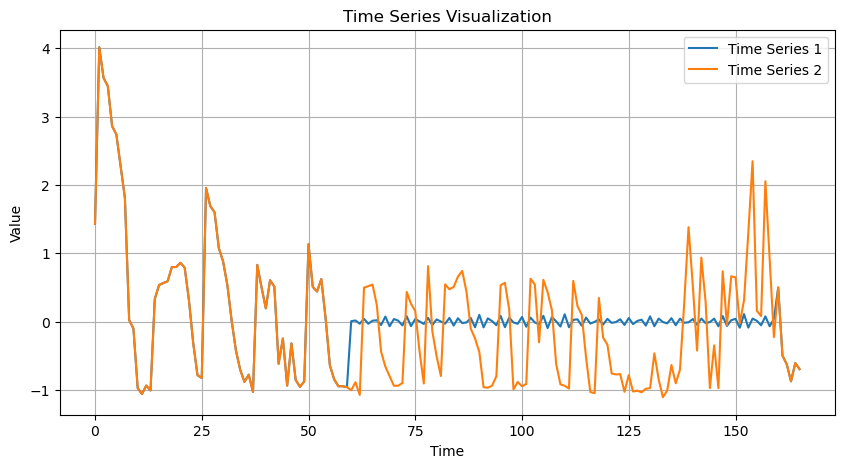

In [108]:
import numpy as np
import matplotlib.pyplot as plt

new1 = x_test_new1[5]
orig = x_test_original[5]

# 创建一个时间轴，对应于时间序列的索引
time_axis = np.arange(len(new1))

# 使用matplotlib绘制时间序列
plt.figure(figsize=(10, 5))  # 设置图形的大小
plt.plot(time_axis, new1, label='Time Series 1')  # 绘制第一个时间序列
plt.plot(time_axis, orig, label='Time Series 2')  # 绘制第二个时间序列

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Time Series Visualization')
plt.xlabel('Time')
plt.ylabel('Value')

# 显示网格
plt.grid(True)

# 显示图形
plt.show()

In [102]:
print(x_test_new1[4])

[[ 4.16208430e+00]
 [ 4.07724930e+00]
 [ 3.64773570e+00]
 [ 3.55307800e+00]
 [ 3.06007710e+00]
 [ 2.83883830e+00]
 [ 2.55300630e+00]
 [ 2.18873080e+00]
 [ 1.58865010e+00]
 [ 1.29684960e+00]
 [ 9.75661970e-01]
 [ 7.70482960e-01]
 [ 1.03739580e-01]
 [-6.86493960e-01]
 [ 1.36156820e+00]
 [ 1.21955030e+00]
 [ 9.21151820e-01]
 [ 7.63629300e-01]
 [ 3.80072290e-01]
 [ 8.72798210e-02]
 [-1.63780460e-01]
 [-4.84588720e-01]
 [-8.10387170e-01]
 [-6.51301700e-01]
 [-5.64760620e-01]
 [-6.33635770e-01]
 [ 1.85405080e+00]
 [ 1.55584690e+00]
 [ 1.29271240e+00]
 [ 6.77279640e-01]
 [ 3.09752580e-01]
 [-3.29758730e-02]
 [-3.54486870e-01]
 [-3.69906260e-01]
 [-3.79471470e-01]
 [-4.52833260e-01]
 [-7.76229670e-01]
 [-8.40527530e-01]
 [ 4.85594850e-01]
 [ 1.19466860e+00]
 [ 5.43807420e-01]
 [ 5.54548940e-01]
 [-3.64158630e-01]
 [-6.00132850e-01]
 [-6.48471890e-01]
 [-5.97370140e-01]
 [-7.18900470e-01]
 [-7.16382110e-01]
 [-8.18931670e-01]
 [-7.27139220e-01]
 [-9.06545420e-01]
 [ 1.01438610e+00]
 [ 6.8723224